In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import datetime
# dataloader
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
sys.path.append('../sys_model/')

from sys_model_dataset import  SysModelDataset

# Import pytorch_lightning model
import pytorch_lightning as pl
from system_model import SysModel

# make jupytre relode modules when they change
%load_ext autoreload
%autoreload 2

# Load dataset for getting pasts

In [2]:
# csv file path
sys_model_df = pd.read_csv('../../../../misc/recorded_data/tick_based_100hz_23-02-19.csv')

In [115]:
window_input_size = 30

evolve_iterations = 50

ar_dataset = SysModelDataset(
    df=sys_model_df,
    num_time_steps_before=window_input_size,
    num_time_steps_after=evolve_iterations
)

In [116]:
# Create dataloader
ar_dataloader = DataLoader(ar_dataset, batch_size=1, shuffle=True, num_workers=8)

# sys model

In [5]:
# load model
sys_model = SysModel(
    num_past_time_steps = 30,
    num_input_vars = 2,
    num_output_vars = 1,
    num_internal_vars = 4,
)
sys_model.load_state_dict(torch.load('../sys_model/sys_model_2023-02-22_15-19-49.pt'))

<All keys matched successfully>

# Plotting

In [265]:
# Get a batch
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)

In [266]:
outputs_predicted = outputs.clone()
interals_predicted = interals.clone()
for i in range(0, inputs.shape[2]- window_input_size):
    # concatenate past and future to get the model input

    next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_input_size], outputs_predicted[:, :, i:i+window_input_size], interals_predicted[:, :, i:i+window_input_size])
    outputs_predicted[:, :, i+window_input_size] = next_predicted_output[:,:,0]
    interals_predicted[:, :, i+window_input_size] = next_predicted_internal[:,:,0]

In [286]:
# Plot base truth
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].numpy())
plt.title('Actual evolution')
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

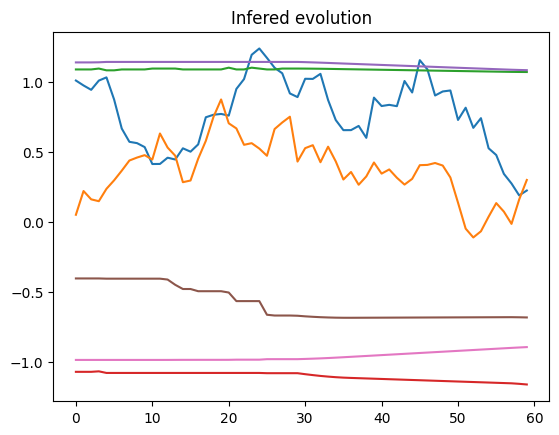

In [268]:
# Plot infered evolution
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].detach().numpy())
for i in range(outputs_predicted.shape[1]):
    plt.plot(outputs_predicted[0, i, :].detach().numpy())
for i in range(interals_predicted.shape[1]):
    plt.plot(interals_predicted[0, i, :].detach().numpy())
plt.title('Infered evolution')
plt.show()
# Add title

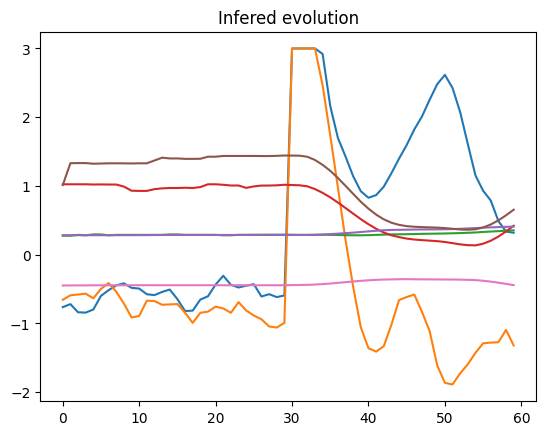

In [15]:
# Plot infered evolution
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].detach().numpy())
for i in range(outputs_predicted.shape[1]):
    plt.plot(outputs_predicted[0, i, :].detach().numpy())
for i in range(interals_predicted.shape[1]):
    plt.plot(interals_predicted[0, i, :].detach().numpy())
plt.title('Infered evolution')
plt.show()
# Add title

In [14]:
# Createa function that calculates how well the system evolved based on a given input
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)

In [31]:
flex_myobrick_pwm = inputs[0, 0, :].numpy()
extend_myobrick_pwm = inputs[0, 1, :].numpy()
angle = outputs[0, 0, :].numpy()
flex_myobrick_torque_encoder = interals[0, 0, :].numpy()
flex_myobrick_pos_encoder = interals[0, 1, :].numpy()
extend_myobrick_torque_encoder = interals[0, 2, :].numpy()
extend_myobrick_pos_encoder = interals[0, 3, :].numpy()

In [56]:
infered_angle = outputs_predicted[0, 0, :].detach().numpy()
infered_flex_myobrick_torque_encoder = interals_predicted[0, 0, :].detach().numpy()
infered_flex_myobrick_pos_encoder = interals_predicted[0, 1, :].detach().numpy()
infered_extend_myobrick_torque_encoder = interals_predicted[0, 2, :].detach().numpy()
infered_extend_myobrick_pos_encoder = interals_predicted[0, 3, :].detach().numpy()

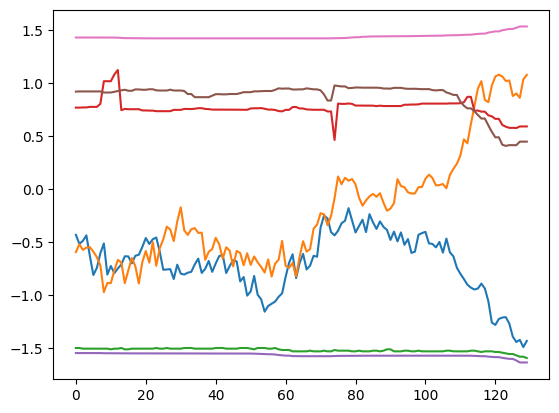

In [58]:
# Plot
plt.plot(flex_myobrick_pwm)
plt.plot(extend_myobrick_pwm)
plt.plot(angle)
plt.plot(flex_myobrick_torque_encoder)
plt.plot(flex_myobrick_pos_encoder)
plt.plot(extend_myobrick_torque_encoder)
plt.plot(extend_myobrick_pos_encoder)
plt.show()

# Optimal torque

In [6]:

# means and std of internal channels before normalization
internal_channel_means = [-2.0340237e+03,  6.3358569e-01, -2.1668540e+03,  1.4289156e+01]
internal_channel_stds = [1.1323308e+03, 1.1938887e+00, 1.2715853e+03, 1.0630209e+00]

In [7]:
optimal_torque_encoder_value_pre_norm = -900
optimal_torque_encoder_value = (optimal_torque_encoder_value_pre_norm - (-2.0340237e+03)) / 1.1323308e+03
optimal_torque_encoder_value

1.0014950578046626

# Calculate optimal future pwm
Calcualte the optimal future pwm to get as close to the desired future postion as possible while still maintaining the optimal torque.

In [122]:
def calc_optim_future_input(
        past_inputs,
        past_outputs,
        past_interals,
        future_desired_outputs,
        max_iterations=1000,
):
    # Init future inputs with zeros
    future_inputs = torch.zeros(past_inputs.shape[0], past_inputs.shape[1], future_desired_outputs.shape[2])

    sys_model.train()
    future_inputs.requires_grad = True

    outputs = torch.cat((past_outputs, torch.zeros(past_inputs.shape[0], past_outputs.shape[1], future_desired_outputs.shape[2])), dim=2)
    interals = torch.cat((past_interals, torch.zeros(past_inputs.shape[0], past_interals.shape[1], future_desired_outputs.shape[2])), dim=2)


    optimizer = torch.optim.SGD([future_inputs], lr=30, momentum=0.9)

    for ii in range(0, max_iterations):
        inputs = torch.cat((past_inputs, future_inputs), dim=2)

        # reset gradients
        optimizer.zero_grad()
        for i in sys_model.parameters():
            i.grad = None


        outputs_predicted = outputs.clone()
        interals_predicted = interals.clone()
        for i in range(0, inputs.shape[2]- window_input_size):
            # concatenate past and future to get the model input

            next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_input_size], outputs_predicted[:, :, i:i+window_input_size], interals_predicted[:, :, i:i+window_input_size])
            outputs_predicted[:, :, i+window_input_size] = next_predicted_output[:,:,0]
            interals_predicted[:, :, i+window_input_size] = next_predicted_internal[:,:,0]


        future_infered_angle = outputs_predicted[:, 0, window_input_size:]
        future_infered_flex_myobrick_torque_encoder = interals_predicted[:, 0, window_input_size:]
        future_infered_extend_myobrick_torque_encoder = interals_predicted[:, 2, window_input_size:]

        # Calculate cost
        angle_loss = torch.mean((future_infered_angle - future_desired_outputs) ** 2)
        flex_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_flex_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
        extend_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_extend_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
        loss = 5 * angle_loss + flex_torque_loss + extend_torque_loss


        loss.backward()

        optimizer.step()

        # Clip future inputs to be between -3 and 3
        future_inputs.data.clamp_(-3, 3)


    future_optimized_inputs = future_inputs
    future_infered_outputs = outputs_predicted[:, :, window_input_size:]
    future_infered_interals = interals_predicted[:, :, window_input_size:]
    
    return future_optimized_inputs, future_infered_outputs, future_infered_interals

In [121]:
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

future_optimized_inputs, future_infered_outputs, future_infered_interals = calc_optim_future_input(
    past_inputs,
    past_outputs,
    past_interals,
    future_outputs,
)

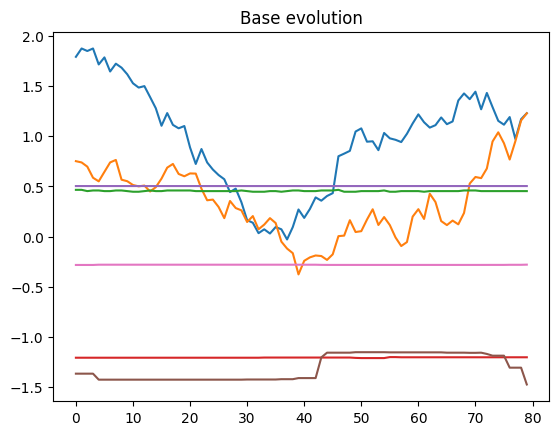

In [123]:
inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)

# Plot infered evolution
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].detach().numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].detach().numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].detach().numpy())
plt.title('Base evolution')
plt.show()
# Add title

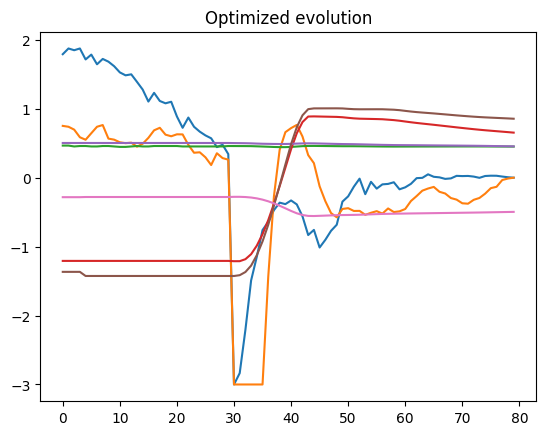

In [124]:
inputs = torch.cat((past_inputs, future_optimized_inputs), dim=2)
outputs = torch.cat((past_outputs, future_infered_outputs), dim=2)
interals = torch.cat((past_interals, future_infered_interals), dim=2)

# Plot infered evolution
for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].detach().numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].detach().numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].detach().numpy())
plt.title('Optimized evolution')
plt.show()
# Add title

# Generation of data pints

In [73]:
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

sys_model.train()
future_inputs.requires_grad = True

inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)# Make inference.



optimizer = torch.optim.SGD([future_inputs], lr=30, momentum=0.9)

In [54]:
future_inputs.grad

tensor([[[-3.4857e-04, -4.5553e-04, -5.4450e-04, -6.3967e-04, -7.1991e-04,
          -7.7147e-04, -8.1563e-04, -8.4155e-04, -8.6214e-04, -8.5916e-04,
          -8.4133e-04, -8.1167e-04, -7.8540e-04, -7.6181e-04, -7.5127e-04,
          -7.1545e-04, -6.5235e-04, -5.9852e-04, -5.1562e-04, -4.3327e-04,
          -3.6443e-04, -2.9048e-04, -1.9810e-04, -1.2708e-04, -6.2903e-05,
          -4.1194e-05, -2.3240e-05, -1.1703e-05, -4.2125e-06,  0.0000e+00],
         [ 1.4539e-04,  1.2097e-04,  1.2482e-04,  8.6448e-05,  7.5457e-05,
           4.8920e-05,  5.5300e-05,  2.4731e-05,  8.1369e-06,  1.0833e-05,
          -3.1313e-06, -3.2864e-05, -1.6911e-05, -3.7145e-05, -5.0407e-05,
          -5.8754e-05, -5.5675e-05, -7.0346e-05, -5.9589e-05, -4.5862e-05,
          -5.2094e-05, -6.9865e-05, -6.0338e-05, -6.5688e-05, -2.5246e-05,
          -1.8870e-05, -1.1169e-05, -5.4046e-06, -1.2024e-06,  0.0000e+00]]])

In [86]:
# reset gradients
optimizer.zero_grad()
for param in sys_model.parameters():
    param.grad = None


outputs_predicted = outputs.clone()
interals_predicted = interals.clone()
for i in range(0, inputs.shape[2]- window_input_size):
    # concatenate past and future to get the model input

    next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_input_size], outputs_predicted[:, :, i:i+window_input_size], interals_predicted[:, :, i:i+window_input_size])
    outputs_predicted[:, :, i+window_input_size] = next_predicted_output[:,:,0]
    interals_predicted[:, :, i+window_input_size] = next_predicted_internal[:,:,0]


future_infered_angle = outputs_predicted[:, 0, window_input_size:]
future_infered_flex_myobrick_torque_encoder = interals_predicted[:, 0, window_input_size:]
future_infered_extend_myobrick_torque_encoder = interals_predicted[:, 2, window_input_size:]

# Calculate cost
angle_loss = torch.mean((future_infered_angle - future_outputs) ** 2)
flex_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_flex_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
extend_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_extend_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
loss = 5 * angle_loss + flex_torque_loss + extend_torque_loss

In [87]:

loss.backward()


In [90]:
future_inputs

tensor([[[-0.0831, -0.0184, -0.0096,  0.0486,  0.0531, -0.0140,  0.1238,
           0.3034,  0.4721,  0.6026,  0.5092,  0.7051,  0.7238,  0.6612,
           0.8479,  0.8493,  0.8090,  0.6736,  0.8035,  1.0184,  1.0255,
           1.1172,  1.0654,  1.0901,  1.0160,  1.1111,  1.1431,  1.1400,
           1.1098,  1.1270],
         [ 1.2577,  1.3061,  1.3373,  1.2895,  1.4180,  1.3117,  1.2109,
           1.0606,  1.0855,  1.1057,  1.2473,  1.3504,  1.4167,  1.4539,
           1.4309,  1.5810,  1.6413,  1.5612,  1.6507,  1.6907,  1.6433,
           1.7128,  1.7057,  1.8574,  1.8675,  1.8770,  1.7115,  1.6189,
           1.7248,  1.7816]]], requires_grad=True)

In [91]:

optimizer.step()


In [92]:
future_inputs

tensor([[[-0.1109, -0.0505, -0.0443,  0.0081,  0.0080, -0.0625,  0.0741,
           0.2571,  0.4253,  0.5559,  0.4630,  0.6612,  0.6826,  0.6230,
           0.8125,  0.8171,  0.7798,  0.6475,  0.7818,  0.9996,  1.0107,
           1.1072,  1.0595,  1.0884,  1.0155,  1.1116,  1.1437,  1.1396,
           1.1097,  1.1270],
         [ 0.9816,  1.0361,  1.0814,  1.0519,  1.2016,  1.1253,  1.0492,
           0.9260,  0.9761,  1.0112,  1.1734,  1.2798,  1.3495,  1.3899,
           1.3704,  1.5248,  1.5894,  1.5140,  1.6081,  1.6527,  1.6101,
           1.6842,  1.6815,  1.8377,  1.8525,  1.8662,  1.7046,  1.6152,
           1.7236,  1.7816]]], requires_grad=True)

In [93]:

# Clip future inputs to be between -3 and 3
future_inputs.data.clamp_(-3, 3)


print(loss)

tensor(0.0327, grad_fn=<AddBackward0>)


In [8]:
sys_ctrl_dataset = []

In [9]:
num_dataset_samples_to_generate = 1000

In [47]:
for i in range(0, num_dataset_samples_to_generate):
    print('Starting sample ' + str(i))

    past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

    sys_model.train()
    future_inputs.requires_grad = True

    inputs = torch.cat((past_inputs, future_inputs), dim=2)
    outputs = torch.cat((past_outputs, future_outputs), dim=2)
    interals = torch.cat((past_interals, future_interals), dim=2)# Make inference.


    optimizer = torch.optim.SGD([future_inputs], lr=30, momentum=0.9)

    max_iterations = 400
    for ii in range(0, max_iterations):

        # reset gradients
        optimizer.zero_grad()
        for i in sys_model.parameters():
            i.grad = None


        outputs_predicted = outputs.clone()
        interals_predicted = interals.clone()
        for i in range(0, inputs.shape[2]- window_input_size):
            # concatenate past and future to get the model input

            next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_input_size], outputs_predicted[:, :, i:i+window_input_size], interals_predicted[:, :, i:i+window_input_size])
            outputs_predicted[:, :, i+window_input_size] = next_predicted_output[:,:,0]
            interals_predicted[:, :, i+window_input_size] = next_predicted_internal[:,:,0]


        future_infered_angle = outputs_predicted[:, 0, window_input_size:]
        future_infered_flex_myobrick_torque_encoder = interals_predicted[:, 0, window_input_size:]
        future_infered_extend_myobrick_torque_encoder = interals_predicted[:, 2, window_input_size:]

        # Calculate cost
        angle_loss = torch.mean((future_infered_angle - future_outputs) ** 2)
        flex_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_flex_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
        extend_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_extend_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
        loss = 5 * angle_loss + flex_torque_loss + extend_torque_loss


        loss.backward()

        optimizer.step()

        # Clip future inputs to be between -3 and 3
        future_inputs.data.clamp_(-3, 3)


        print(loss)

        if loss < 0.005:
            # Save to csv
            # - past inputs
            # - past outputs
            # - past internals
            # - future outputs
            # - first future inputs

            to_save = {
                'past_inputs': past_inputs[0, :, :].detach().numpy(),
                'past_outputs': past_outputs[0, :, :].detach().numpy(),
                'past_interals': past_interals[0, :, :].detach().numpy(),
                'future_outputs': future_outputs[0, :, :].detach().numpy(),
                'future_inputs': future_inputs[0, :, 0].detach().numpy(),
            }

            sys_ctrl_dataset.append(to_save)

            print('One sample saved!')

            db1.set_item('log', 'generated samples ' + str(len(sys_ctrl_dataset)))


            break

    


# save dataset as pickle
now = datetime.now()
with open(f'sys_ctrl_dataset_{now.strftime("%Y%m%d_%H%M%S")}.pickle', 'wb') as handle:
    pickle.dump(sys_ctrl_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

db1.set_item('log', 'finished, saved ' + str(len(sys_ctrl_dataset)) + ' samples')


Starting sample 0
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(

KeyboardInterrupt: 

In [310]:
len(sys_ctrl_dataset)

61

In [88]:
import db1

In [200]:
future_infered_angle = outputs_predicted[:, 0, window_input_size:]
future_infered_flex_myobrick_torque_encoder = interals_predicted[:, 0, window_input_size:]
future_infered_extend_myobrick_torque_encoder = interals_predicted[:, 2, window_input_size:]

In [201]:
# Calculate cost
angle_loss = torch.mean((future_infered_angle - future_outputs) ** 2)

In [202]:
# leaky relu
flex_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_flex_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)
extend_torque_loss = torch.mean(torch.nn.functional.leaky_relu(future_infered_extend_myobrick_torque_encoder - optimal_torque_encoder_value, negative_slope=-0.05) ** 2)

In [203]:
loss = angle_loss + flex_torque_loss + extend_torque_loss

In [205]:
loss.backward()

In [206]:
future_inputs.grad

tensor([[[-1.6662e-03, -1.6972e-03, -1.7653e-03, -1.7953e-03, -1.7746e-03,
          -1.7203e-03, -1.6942e-03, -1.7215e-03, -1.7739e-03, -1.8505e-03,
          -2.0540e-03, -2.3029e-03, -2.4741e-03, -2.6241e-03, -2.8583e-03,
          -3.1687e-03, -3.5154e-03, -3.7875e-03, -3.9442e-03, -4.0002e-03,
          -3.9471e-03, -3.8408e-03, -3.7456e-03, -3.5088e-03, -3.2171e-03,
          -2.8099e-03, -2.4585e-03, -2.0915e-03, -1.8810e-03, -1.6033e-03,
          -1.3632e-03, -1.1227e-03, -9.0293e-04, -6.8039e-04, -5.4903e-04,
          -4.5402e-04, -4.5007e-04, -4.7085e-04, -4.5736e-04, -4.3151e-04,
          -4.2172e-04, -3.6850e-04, -2.9765e-04, -2.2085e-04, -1.4665e-04,
          -8.9069e-05, -4.7276e-05, -2.0369e-05, -5.8770e-06,  0.0000e+00],
         [ 1.6069e-03,  1.6972e-03,  1.6738e-03,  1.6954e-03,  1.6398e-03,
           1.6547e-03,  1.5503e-03,  1.5605e-03,  1.5000e-03,  1.4895e-03,
           1.3854e-03,  1.2784e-03,  1.0416e-03,  8.9078e-04,  6.2599e-04,
           4.6079e-04,  

In [207]:

# Perform one step of the optimizer to update the paramerers (weights) of the model.
optimizer.step()

In [208]:
print(loss)
# tensor(0.0173, grad_fn=<MeanBackward0>)

tensor(0.0154, grad_fn=<AddBackward0>)


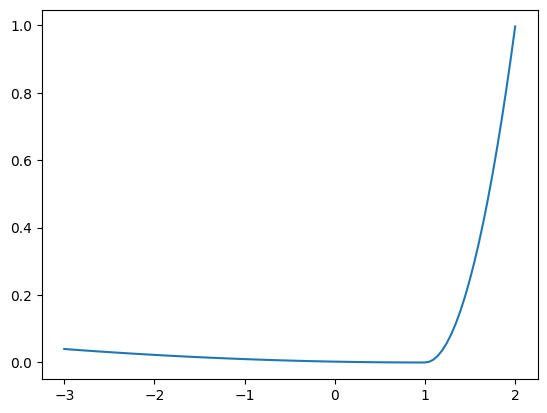

In [179]:
# plot leaky relu
x = np.linspace(-3, 2, 100)
x = torch.tensor(x)

y= [torch.nn.functional.leaky_relu(i - optimal_torque_encoder_value, negative_slope=-0.05) ** 2 for i in x]
plt.plot(x, y)

In [ ]:
# clamb input pwm to range
for _ in range(epochs):
    loss = ...
    optimizer.step()
    for p in model.parameters():
        p.data.clamp_(-1.0, 1.0)